# 线性回归
假设（房屋价格）可以表示为特征（面积和房龄）的加权和，如下面的式子：
$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b.$$
![线性回归是一个单层神经网络。](../img/singleneuron.svg)

In [1]:
%matplotlib inline
import random

import torch
from g2fl import dl as dl

## 生成数据集
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [5]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.6938,  1.6380]) 
label: tensor([-2.7574])


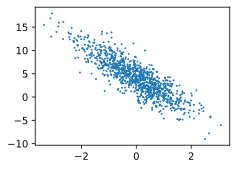

In [6]:
dl.set_figsize()
dl.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 读取数据集
该函数能打乱数据集中的样本并以小批量方式获取数据。

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [8]:
batch_size = 10

In [9]:
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0516, -1.3693],
        [ 0.6210, -0.5763],
        [-0.4129,  0.8628],
        [-0.1666, -1.3278],
        [-0.2685,  0.8511],
        [ 0.6492, -0.6263],
        [-1.5868, -1.0207],
        [-0.7567,  0.1303],
        [-0.0945,  0.0608],
        [ 0.6306,  1.6235]]) 
 tensor([[ 8.9626],
        [ 7.4102],
        [ 0.4366],
        [ 8.3889],
        [ 0.7715],
        [ 7.6076],
        [ 4.4994],
        [ 2.2398],
        [ 3.7991],
        [-0.0540]])


## 初始化模型参数
通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。

In [10]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [11]:
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [12]:
def squared_loss(y_hat, y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法
批量梯度下降法，数据量很大

随机梯度下降,训练数据中会存在一些错误样本或者噪声数据，那么在一次用到该数据的迭代中，优化的方向肯定不是朝着最理想的方向前进的，也就会导致训练效果（比如准确率）的下降

小批量梯度下降

In [13]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练


In [14]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.032440
epoch 2, loss 0.000121
epoch 3, loss 0.000053


In [16]:
print(f'w的估计误差:{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b -b}')

w的估计误差:tensor([-0.0006,  0.0003], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0003], grad_fn=<RsubBackward1>)


## 计算图

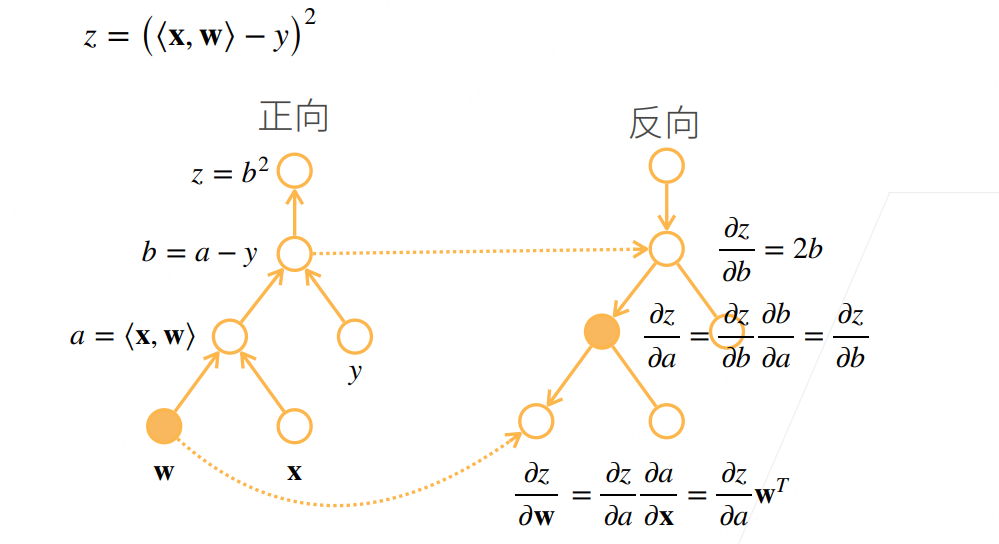

## 梯度下降

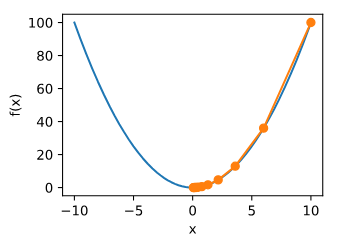